In [ ]:
!pip install https://dl.google.com/coral/python/tflite_runtime-2.1.0.post1-cp36-cp36m-linux_x86_64.whl

In [1]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import tflite_runtime.interpreter as tflite

In [2]:
DATA_PATH = '/vsicurl/https://data.tern.org.au/rs/public/data/sentinel2/surface_reflectance/nsw/cvmsre_nsw_m202003202005_abma2.tif'
FC_MODEL = 'fcModel_256x64x256.tflite'

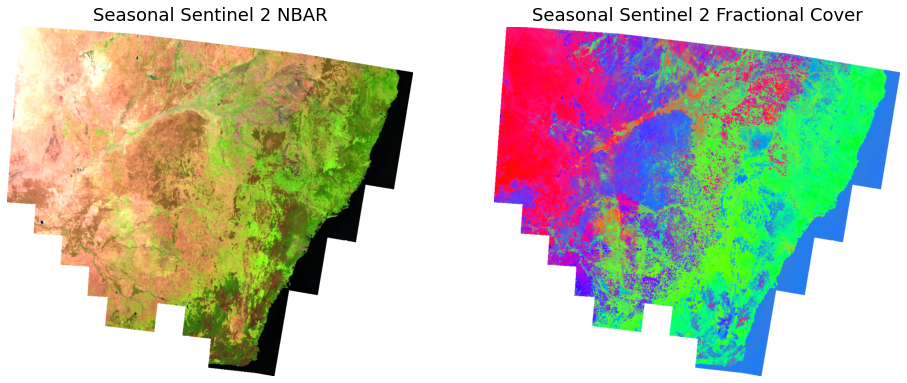

In [1]:
# The unmixing model
def unmixfc(nbar):
    # Get the shape of the input array
    inshape = nbar.shape
    
    # Flatten and scale reflectance
    nbar = np.reshape(nbar,(inshape[0],-1)) / 10000.0

    # Convert Sentinel 2 to Landsat 7 and drop the blue band
    nbar = (np.transpose(nbar) *
                    np.array([0.9551, 1.0582, 0.9871, 1.0187, 0.9528, 0.9688]) + 
                    np.array([-0.0022, 0.0031, 0.0064, 0.012, 0.0079, -0.0042]))[:,1:]

    # Run the prediction using TFLite
    fcModel = tflite.Interpreter(model_path=FC_MODEL)
    inputDetails = fcModel.get_input_details()
    outputDetails = fcModel.get_output_details()
    fcModel.resize_tensor_input(inputDetails[0]['index'], nbar.shape)
    fcModel.allocate_tensors()
    fcModel.set_tensor(inputDetails[0]['index'], nbar.astype(np.float32))
    fcModel.invoke()
    fcLayers = fcModel.get_tensor(outputDetails[0]['index'])

    # Clean up low/high values
    fcLayers = np.clip(fcLayers.T,0,2)
    fcLayerSum = fcLayers.sum(axis=0) + np.finfo('float32').eps
    outputFC = np.round(100 * fcLayers/fcLayerSum, 0)
    
    # Set noData as 255
    outputFC[:,nbar[:,0] < 0.001] = 255
    outputFC[:,nbar[:,0] > 0.999] = 255
    # Reshape the FC Output
    out = sklearn_unflatten(outputFC, ds).astype(np.uint8)
    
    return out



In [11]:
refDataSet = rasterio.open(DATA_PATH)

# Read in the imagery at an overview level
overviewLevel = 2048
refData = refDataSet.read(
        out_shape=(refDataSet.count,
                   int(refDataSet.height / overviewLevel),
                   int(refDataSet.width / overviewLevel)))

refData

array([[[32767, 32767,  1532, ..., 32767, 32767, 32767],
        [32767, 32767,  1664, ..., 32767, 32767, 32767],
        [32767, 32767,  1537, ..., 32767, 32767, 32767],
        ...,
        [32767, 32767, 32767, ..., 32767, 32767, 32767],
        [32767, 32767, 32767, ..., 32767, 32767, 32767],
        [32767, 32767, 32767, ..., 32767, 32767, 32767]],

       [[32767, 32767,  2349, ..., 32767, 32767, 32767],
        [32767, 32767,  2548, ..., 32767, 32767, 32767],
        [32767, 32767,  2425, ..., 32767, 32767, 32767],
        ...,
        [32767, 32767, 32767, ..., 32767, 32767, 32767],
        [32767, 32767, 32767, ..., 32767, 32767, 32767],
        [32767, 32767, 32767, ..., 32767, 32767, 32767]],

       [[32767, 32767,  3456, ..., 32767, 32767, 32767],
        [32767, 32767,  3859, ..., 32767, 32767, 32767],
        [32767, 32767,  3939, ..., 32767, 32767, 32767],
        ...,
        [32767, 32767, 32767, ..., 32767, 32767, 32767],
        [32767, 32767, 32767, ..., 32767, 327

In [12]:
nbar=refData

In [17]:
inshape=nbar.shape
inshape

(6, 58, 68)

In [18]:
# Flatten and scale reflectance
nbar = np.reshape(nbar,(inshape[0],-1)) / 10000.0
nbar.shape

(6, 3944)

In [19]:
nbar = (np.transpose(nbar) *
                    np.array([0.9551, 1.0582, 0.9871, 1.0187, 0.9528, 0.9688]) + 
                    np.array([-0.0022, 0.0031, 0.0064, 0.012, 0.0079, -0.0042]))[:,1:]
nbar.shape

(3944, 5)